# Provisioning Factors, Master Thesis

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

## Loading the dataset

Load the data, remove inf values and extract countries, variables

In [21]:
all_in_one = pd.read_csv('../data/all_in_one.csv', index_col=0)

In [22]:
all_in_one_no_inf = all_in_one.replace([np.inf, -np.inf], np.nan)
all_variables = all_in_one_no_inf.drop(columns=["Year", "Country.Code", "Country.Name"])
all_countries = all_in_one_no_inf['Country.Name'].unique()

Apply basic styles and a color scheme to all plots. Ignore selected warnings.

In [23]:
# Prepare a color palette for all unique countries in the dataset
sns.set_theme(style="dark")
palette = dict(zip(all_countries, sns.color_palette("husl", len(all_countries))))

In [24]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Create panel data set for each outcome variable.
Start with year 1995 where ecirank data is available, end with 2015, the last year for which energy data is available. 
Only keep observations where energy use data is available.
Remove selected columns (selection process?)

In [25]:
all_in_one_selected_years = all_in_one_no_inf.loc[all_in_one_no_inf['Year'].between(1995, 2015)]
all_in_one_selected_years_with_energy_only = all_in_one_selected_years[
    all_in_one_selected_years[['energy']].notnull().all(1)]

Drop stock variables, only keep flow

In [26]:
stock_variables = ['netmigration', 'wealth', 'patents', 'concentration', 'selfemployed', 'grosscapital', 'gdppercap',
                   'gnipercap', 'trade', 'gini', 'corruption', 'mobilecellular']
all_in_one_selected_cols = all_in_one_selected_years_with_energy_only.drop(
    columns=stock_variables)

For cross-sectional analysis filter the data frame by year 2012

In [27]:
all_in_one_selected_cols_2012 = all_in_one_selected_cols.loc[
    all_in_one_selected_cols['Year'] == 2012]

Begin subsetting the data. Assign outcome variables and indicators to separate data frames.

In [28]:
from functions.create_panel_dataset import remove_cols_with_few_observations, create_outcome_df_with_metadata, \
    remove_outliers_iqr

In [29]:
outcome_variables = ['lifeexpectancy_over_energy', 'nutrition_over_energy', 'education_over_energy',
                     'sanitation_over_energy']
indicator_index_offset = 3
outcome_index_offset = 17

Create separate data frames containing observations with data available for each outcome variable. Remove columns with few observations.
After subsetting is done, create final data frames with metadata.

In [30]:
outcome_dfs_with_metadata = {}
for outcome in outcome_variables:
    outcome_df = all_in_one_selected_cols.dropna(subset=[outcome])
    outcome_df_no_outliers = remove_outliers_iqr(outcome_df)
    outcome_df_no_outliers_no_few_obs = remove_cols_with_few_observations(outcome_df_no_outliers)

    outcome_df_with_metadata = create_outcome_df_with_metadata(
        outcome_df_no_outliers_no_few_obs, outcome, indicator_index_offset, outcome_index_offset
    )
    outcome_dfs_with_metadata[outcome] = outcome_df_with_metadata

In [31]:
outcome_dfs_with_metadata_2012 = {}
for outcome in outcome_variables:
    outcome_df_2012 = all_in_one_selected_cols_2012.dropna(subset=[outcome])
    outcome_df_no_outliers_2012 = remove_outliers_iqr(outcome_df_2012)
    outcome_df_no_outliers_no_few_obs_2012 = remove_cols_with_few_observations(outcome_df_no_outliers_2012)

    outcome_df_with_metadata_2012 = create_outcome_df_with_metadata(
        outcome_df_no_outliers_no_few_obs_2012, outcome, indicator_index_offset, outcome_index_offset
    )
    outcome_dfs_with_metadata_2012[outcome] = outcome_df_with_metadata_2012

## Exploratory analysis

Create a summary data frame for each outcome variable containing the number of observations, countries and years.

In [32]:
from functions.exploratory_analysis import create_summary_df

In [33]:
summary_dfs = {}
indicator_dfs = {}
outcome_dfs = {}
for outcome in outcome_variables:
    outcome_df_with_metadata = outcome_dfs_with_metadata[outcome]
    outcome_df = outcome_df_with_metadata[f"{outcome}_df"]
    outcome_indicators = outcome_df_with_metadata[f"{outcome}_indicators"]
    outcome_outcomes = outcome_df_with_metadata[f"{outcome}_outcome"]
    outcome_countries = outcome_df_with_metadata[f"{outcome}_countries"]
    outcome_all_variables = outcome_df_with_metadata[f"{outcome}_variables"]
    indicator_dfs[outcome] = outcome_indicators
    outcome_dfs[outcome] = outcome_outcomes
    summary_df = create_summary_df(outcome_df, outcome_countries, outcome_all_variables)
    summary_dfs[outcome] = summary_df

In [34]:
summary_dfs_2012 = {}
indicator_dfs_2012 = {}
outcome_dfs_2012 = {}
for outcome in outcome_variables:
    outcome_df_with_metadata_2012 = outcome_dfs_with_metadata_2012[outcome]
    outcome_df_2012 = outcome_df_with_metadata_2012[f"{outcome}_df"]
    outcome_indicators_2012 = outcome_df_with_metadata_2012[f"{outcome}_indicators"]
    outcome_outcomes_2012 = outcome_df_with_metadata_2012[f"{outcome}_outcome"]
    outcome_countries_2012 = outcome_df_with_metadata_2012[f"{outcome}_countries"]
    outcome_all_variables_2012 = outcome_df_with_metadata_2012[f"{outcome}_variables"]
    indicator_dfs_2012[outcome] = outcome_indicators_2012
    outcome_dfs_2012[outcome] = outcome_outcomes_2012
    summary_df_2012 = create_summary_df(outcome_df_2012, outcome_countries_2012, outcome_all_variables_2012)
    summary_dfs_2012[outcome] = summary_df_2012

In [35]:
lifeexp_summary = summary_dfs['lifeexpectancy_over_energy']
lifeexp_indicators = indicator_dfs['lifeexpectancy_over_energy']
lifeexp_outcomes = outcome_dfs['lifeexpectancy_over_energy']

In [36]:
lifeexp_summary_2012 = summary_dfs_2012['lifeexpectancy_over_energy']
lifeexp_indicators_2012 = indicator_dfs_2012['lifeexpectancy_over_energy']
lifeexp_outcomes_2012 = outcome_dfs_2012['lifeexpectancy_over_energy']

Plot the number of observations, countries and years for each outcome variable

In [37]:
from functions.exploratory_analysis import plot_summary_variable

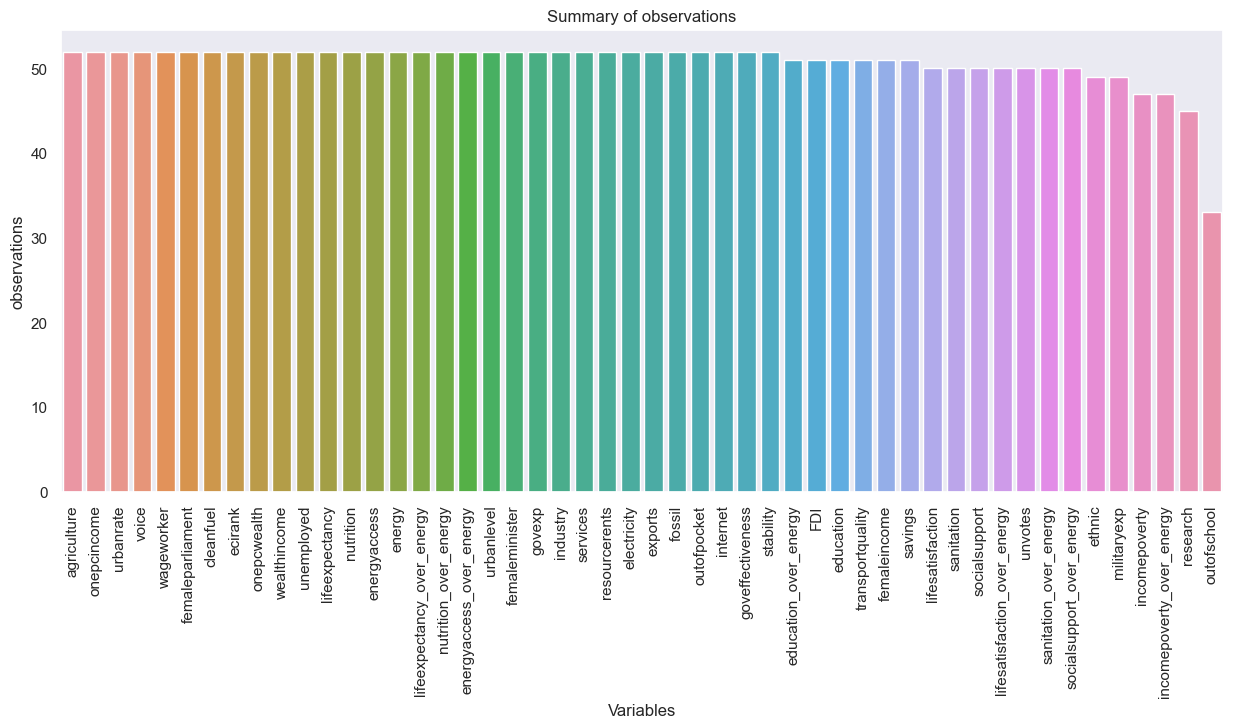

In [54]:
plot_summary_variable(lifeexp_summary, 'observations')
# plot_summary_variable(lifeexp_summary, 'num_countries')
# plot_summary_variable(lifeexp_summary, 'num_years')

Plot histograms for each indicator variable. The chart is big so it's not included by default.

In [39]:
# from functions.exploratory_analysis import plot_histograms

In [40]:
# plot_histograms(lifeexp_indicators, lifeexp_indicators.columns)

Plot outliers. 

In [41]:
from functions.exploratory_analysis import plot_outliers

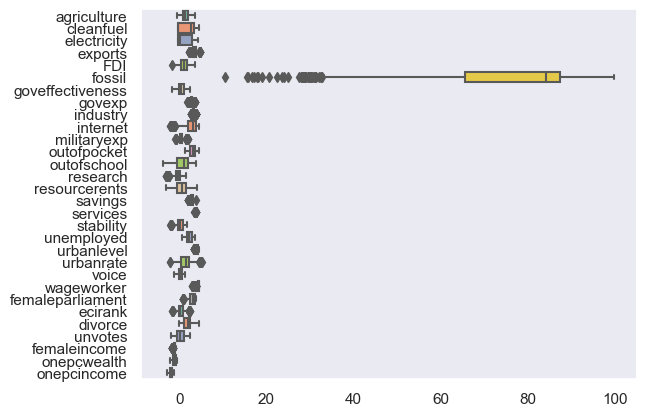

In [42]:
plot_outliers(lifeexp_indicators)

Plot correlation matrix for all indicators.

In [43]:
from functions.exploratory_analysis import plot_correlation_matrix

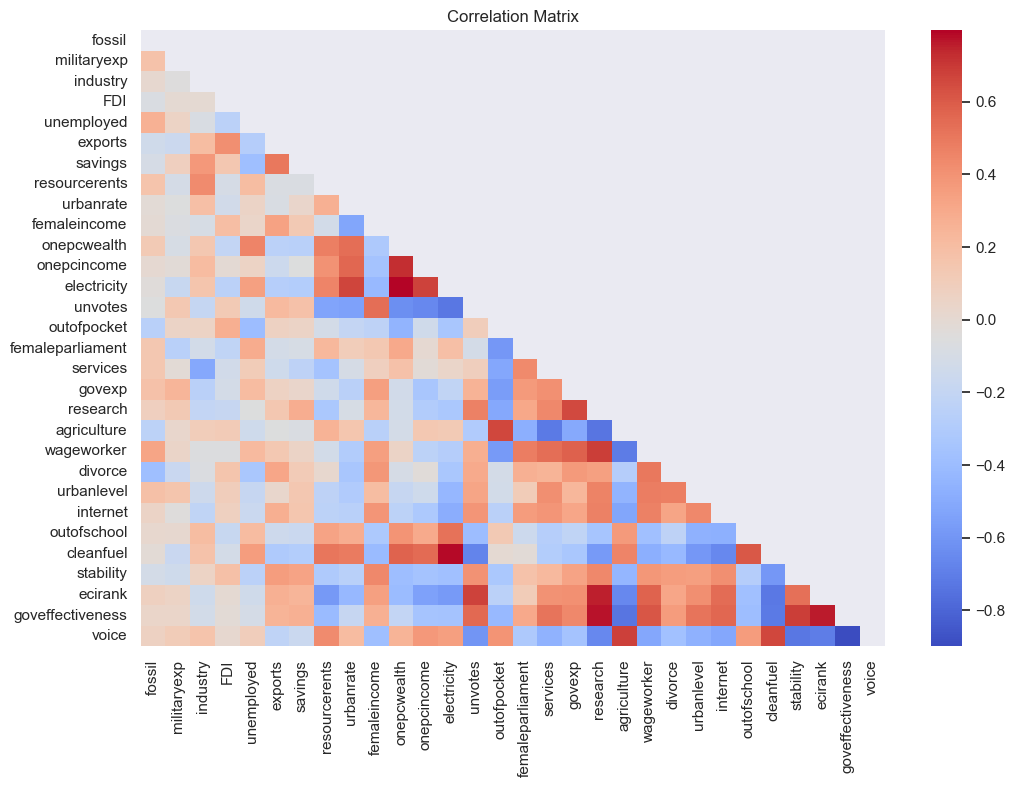

[('voice', 'goveffectiveness', -0.8989465284961966)]

In [44]:
plot_correlation_matrix(lifeexp_indicators)

## Cross-validation: Best subset, Lasso, PCA

In [45]:
from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
# from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from abess import LinearRegression
from functions.cross_validation import panel_cross_validation, plot_cross_validation_results

In [46]:
# Initialize the models
best_subset_model = LinearRegression()
lasso_model = Lasso(max_iter=10000)
pca_model = PCA()

# Combine these into a list
models = [best_subset_model, lasso_model, pca_model]
model_names = ['Best Subset', 'Lasso', 'PCA']

In [47]:
lifeexp_model, lifeexp_cv_results = panel_cross_validation(models, model_names, lifeexp_indicators, lifeexp_outcomes)

Model: Best Subset, Mean MSE: 0.5895, Std MSE: 0.0847, n_splits: 2, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.6250, Std MSE: 0.1608, n_splits: 3, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5223, Std MSE: 0.2211, n_splits: 5, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5515, Std MSE: 0.3659, n_splits: 7, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5505, Std MSE: 0.3788, n_splits: 10, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5292, Std MSE: 0.5187, n_splits: 15, Lasso alpha: None
Model: Lasso, Mean MSE: 0.4636, Std MSE: 0.1426, n_splits: 2, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.5500, Std MSE: 0.1771, n_splits: 3, Lasso alpha: {'alpha': 0.1}
Model: Lasso, Mean MSE: 0.4034, Std MSE: 0.2569, n_splits: 5, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4649, Std MSE: 0.3137, n_splits: 7, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4463, Std MSE: 0.3196, n_splits: 10, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4

In [55]:
lifeexp_model_2012, lifeexp_cv_results_2012 = panel_cross_validation(models, model_names, lifeexp_indicators_2012,
                                                                     lifeexp_outcomes_2012)

Model: Best Subset, Mean MSE: 0.4800, Std MSE: 0.2762, n_splits: 2, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.6324, Std MSE: 0.4133, n_splits: 3, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4329, Std MSE: 0.3711, n_splits: 5, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4291, Std MSE: 0.4125, n_splits: 7, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4839, Std MSE: 0.5194, n_splits: 10, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4636, Std MSE: 0.5506, n_splits: 15, Lasso alpha: None
Model: Lasso, Mean MSE: 0.3093, Std MSE: 0.1957, n_splits: 2, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4245, Std MSE: 0.4248, n_splits: 3, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.2536, Std MSE: 0.2935, n_splits: 5, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.3080, Std MSE: 0.3497, n_splits: 7, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.1846, Std MSE: 0.2725, n_splits: 10, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: na

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/supernaturval/miniconda3/envs/pro

### Anaylzing cross-validation results

In [48]:
from functions.cross_validation import filter_and_find_best_model, plot_cross_validation_results

In [49]:
# plot_cross_validation_results(lifeexp_cv_results)
best_model_no_zero_coef = filter_and_find_best_model(lifeexp_cv_results)
print(best_model_no_zero_coef)

Lasso_5


In [56]:
best_model_no_zero_coef_2012 = filter_and_find_best_model(lifeexp_cv_results_2012)
print(best_model_no_zero_coef_2012)

Lasso_10


### Best model?
For the full panel dataset: Best Model: Lasso, Mean MSE: 0.3953844254470721, n_splits: 7, Lasso alpha: {'alpha': 0.01}
For the cross-section for 2012: Best Model: Lasso, Mean MSE: 0.18459822705946247, n_splits: 10, Lasso alpha: {'alpha': 0.01}

Try removing "selfemployed" column because it's collinear with "wageworker" and "concentration" as an outlier

In [50]:
lifeexp_lasso = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler()),
                          ('model', Lasso(max_iter=10000, alpha=0.01))])

lifeexp_lasso.fit(lifeexp_indicators, lifeexp_outcomes)
lifeexp_lasso_coef = lifeexp_lasso.named_steps['model'].coef_

important_features = []
for i, coef in enumerate(lifeexp_lasso_coef):
    if coef != 0:
        important_features.append((i, coef))

print("Important features:", important_features)
print(lifeexp_lasso.named_steps['model'].intercept_)
indicators_lifeexp_over_energy_important = lifeexp_indicators.iloc[:, [i for i, coef in important_features]]
print(len(indicators_lifeexp_over_energy_important.columns), len(lifeexp_indicators.columns))

Important features: [(0, -0.03956247681227295), (2, 0.14739029224176947), (3, -0.3058383920439079), (4, -0.0806952181660111), (5, 0.012897412537410552), (6, -0.27353011122751714), (7, -0.003057897216442773), (8, 0.039094544038451556), (9, 0.04100661222584565), (10, -0.08188554637541962), (11, -0.0038971742158363685), (13, 0.1638504239788079), (14, 0.15909085961899896), (17, -0.12197309180996027), (18, -0.03386293915556771), (19, -0.00528662874368684), (20, 0.001046705060471879), (21, 0.0253899861828104), (22, -0.061704199019063814), (23, 0.03621393033539112), (24, 0.3468437616935068), (26, 0.024768860456515433), (27, -0.11907591095331525), (28, 0.06848738859481365), (29, 0.04312522470961904)]
1.907523400480515
25 30


In [58]:
lifeexp_lasso_2012 = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler()),
                               ('model', Lasso(max_iter=10000, alpha=0.01))])
lifeexp_lasso_2012.fit(lifeexp_indicators_2012, lifeexp_outcomes_2012)
lifeexp_lasso_coef_2012 = lifeexp_lasso_2012.named_steps['model'].coef_

important_features_2012 = []
for i, coef in enumerate(lifeexp_lasso_coef_2012):
    if coef != 0:
        important_features_2012.append((i, coef))

print("Important features:", important_features_2012)
print(lifeexp_lasso_2012.named_steps['model'].intercept_)
indicators_lifeexp_over_energy_important_2012 = lifeexp_indicators_2012.iloc[:,
                                                [i for i, coef in important_features_2012]]
print(len(indicators_lifeexp_over_energy_important_2012.columns), len(lifeexp_indicators_2012.columns))

Important features: [(0, -0.06470340210126574), (2, 0.06925111632299041), (3, -0.2176441638588178), (4, -0.02546202975740396), (5, 0.06292255853045364), (6, -0.09925178462914235), (9, -0.06261695912926159), (12, -0.02276128324463402), (13, 0.32508580864750536), (15, 0.0646121156033428), (17, -0.3335196105595412), (18, 0.09641534884690284), (19, -0.07685130649973262), (20, 0.08523631109053434), (21, 0.009569271015792288), (25, 0.032727111069755184), (26, 0.20611964467296484), (28, -0.0007415377280107045), (29, 0.11166887104220637), (30, 0.18190440531398272), (31, 0.02968574939171283), (32, -0.03514776301104779)]
2.014005376187386
22 33


## Panel regression with cross-validation

In [51]:
# simple linear regression
from sklearn.linear_model import LinearRegression

lifeexp_lasso_linear = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('model', LinearRegression())])
lifeexp_lasso_linear.fit(indicators_lifeexp_over_energy_important, lifeexp_outcomes)
lifeexp_lasso_linear_coef = lifeexp_lasso_linear.named_steps['model'].coef_
print("Linear regression coefficients:", lifeexp_lasso_linear_coef)
print("Adjusted r squared",
      lifeexp_lasso_linear.score(indicators_lifeexp_over_energy_important, lifeexp_outcomes))

Linear regression coefficients: [-6.41493764e-02  1.14996730e-01 -7.60283789e-01 -8.56135092e-02
  1.32202812e-03 -4.30823539e-01 -4.56804774e-02  2.49301236e-01
  4.55462996e-02 -1.79224431e-01 -4.89826225e-02  2.04889253e-01
  1.17547864e-01 -1.37783286e-01 -1.11575600e-01 -5.76883075e-02
 -7.29029829e-04  1.22379185e-01 -3.35513053e-01  9.34630395e-02
  4.98908209e-01  1.49987673e-01 -8.92081229e-01  2.20176671e-01
  1.61809124e-01]
Adjusted r squared 0.657998098504449


In [59]:
lifeexp_lasso_linear_2012 = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('model', LinearRegression())])
lifeexp_lasso_linear_2012.fit(indicators_lifeexp_over_energy_important_2012, lifeexp_outcomes_2012)
lifeexp_lasso_linear_coef_2012 = lifeexp_lasso_linear_2012.named_steps['model'].coef_
print("Linear regression coefficients:", lifeexp_lasso_linear_coef_2012)
print("Adjusted r squared",
      lifeexp_lasso_linear_2012.score(indicators_lifeexp_over_energy_important_2012, lifeexp_outcomes_2012))

Linear regression coefficients: [-4.42122377e-02  1.14495135e-01 -6.56097451e-01 -2.47078558e-02
  7.01145997e-03 -1.78775179e-01 -1.23383481e-01 -4.71984101e-02
  4.28224832e-01  2.09191628e-01 -8.25408621e-01  1.53915223e-01
 -1.98713111e-01  8.41615900e-01 -1.88932860e-04  1.49919610e-01
  4.04831203e-01 -1.23118691e-02  5.86122856e-01  2.78855956e-01
  4.64680005e-02 -5.95120479e-01]
Adjusted r squared 0.9751070049502248


In [60]:
lifeexp_indicators_2012

,agriculture,cleanfuel,electricity,exports,FDI,fossil,goveffectiveness,govexp,industry,internet,...,wageworker,femaleparliament,femaleminister,ecirank,unvotes,femaleincome,onepcwealth,onepcincome,wealthincome,ethnic
89,2.932089,3.380995,-0.223145,3.365138,2.047868,57.754082,-0.267876,2.383687,3.131947,3.899950,...,3.609294,2.754570,1.902108,-0.331512,0.985717,-1.085301,-1.502828,-2.459239,3.692010,0.137
442,2.885509,1.252763,0.068623,3.316431,1.604773,77.332943,-0.026902,2.389676,3.326010,3.624341,...,4.035525,2.369030,2.351375,0.456774,0.110078,-0.960504,-1.479287,-1.996572,2.915114,0.047
1242,1.814445,4.034241,-0.356675,3.476631,0.945999,91.947803,-0.449273,3.151258,3.073767,3.808095,...,4.285076,3.064725,1.840550,0.667252,NaN,-1.115352,-1.497897,-2.340287,5.156225,0.638
1492,1.488394,2.597491,-0.356675,4.100223,1.278979,72.187100,-0.031450,2.759410,3.234073,3.949319,...,4.482035,3.131864,2.933857,0.601161,0.946278,-0.842111,-1.460156,-1.968974,5.682830,0.288
1792,0.594070,-0.356675,-0.356675,3.412896,1.098669,74.439479,1.756651,3.047273,3.282214,4.418841,...,4.438443,3.205804,3.292126,0.630575,1.945251,-0.963382,-1.416754,-2.008424,4.423755,0.728
2042,1.186298,-0.356675,-0.356675,3.521809,2.501683,70.039442,1.184976,2.511705,3.419636,4.008242,...,4.316464,2.650892,2.901422,-0.180309,-0.272223,-1.075580,-0.663006,-1.325764,3.103104,0.441
2342,1.635270,2.028148,0.179571,3.454780,1.793202,47.884830,0.474561,2.820786,3.100312,3.860730,...,4.347142,3.653161,3.374169,0.243818,-0.213851,-1.105335,-1.062184,-1.717580,2.591555,0.395
2442,1.191643,-0.356675,-0.356675,3.661843,1.048652,72.237762,0.678778,3.083577,3.051065,4.126166,...,4.385175,3.171409,2.954910,0.881764,0.989930,-0.846065,-1.488106,-2.357041,3.451635,0.176
2492,1.348099,2.219203,1.010672,3.239110,NaN,87.464471,-0.407113,3.463078,3.151333,3.054001,...,4.375667,3.811580,3.117950,0.081568,-1.664991,-1.044692,-1.440539,-2.051826,2.024494,0.516
2842,1.686601,2.549445,1.041319,3.202062,1.779893,84.822428,-0.542261,2.291134,3.347102,3.745260,...,3.991076,3.033270,2.564949,-0.087083,-0.468928,-1.052110,-1.181233,-1.251414,1.283096,0.452


Try with selected variables only

In [61]:
indicators_lifeexp_over_energy_2012_selected = lifeexp_indicators_2012.loc[:,
                                               ['goveffectiveness', 'onepcincome', 'resourcerents']]
lifeexp_linear_selected_2012 = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('model', LinearRegression())])
lifeexp_linear_selected_2012.fit(indicators_lifeexp_over_energy_2012_selected, lifeexp_outcomes_2012)
lifeexp_linear_selected_coef_2012 = lifeexp_linear_selected_2012.named_steps['model'].coef_
print("Linear regression coefficients:", lifeexp_linear_selected_coef_2012)
print("Adjusted r squared",
      lifeexp_linear_selected_2012.score(indicators_lifeexp_over_energy_2012_selected, lifeexp_outcomes_2012))

Linear regression coefficients: [0.20616248 1.16077657 0.08593879]
Adjusted r squared 0.34016395977961544


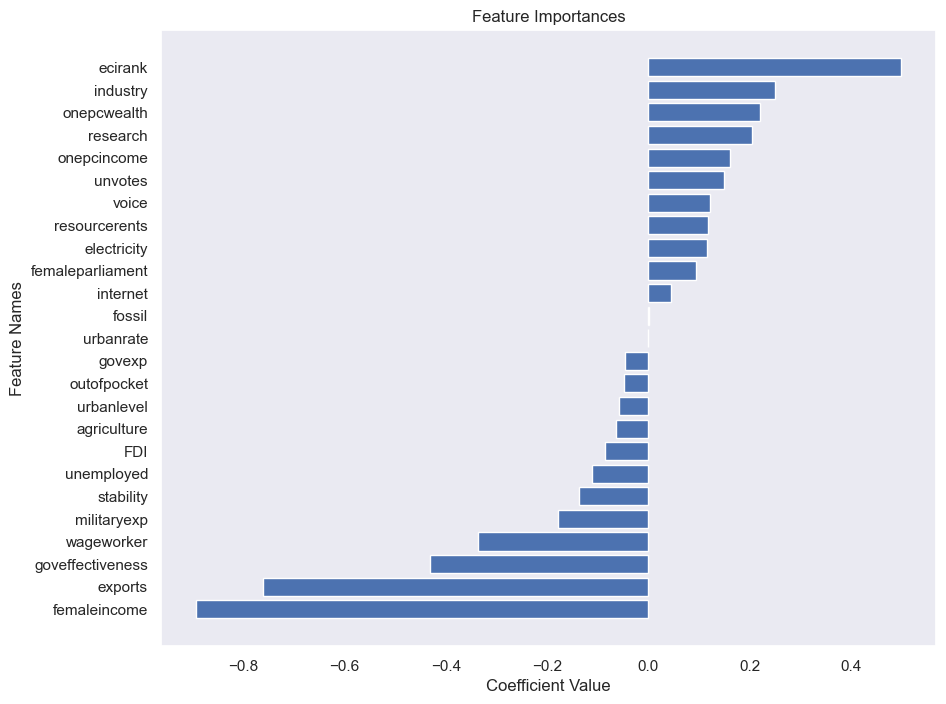

In [53]:
from matplotlib import pyplot as plt

# Extract the feature names from your DataFrame (change this line if your feature names are stored differently)
indicators_lifeexp_over_energy_names = indicators_lifeexp_over_energy_important.columns

# Create a list of (coefficient, feature_name) tuples and sort them based on the coefficients
indicators_lifeexp_over_energy_names_sorted = sorted(
    zip(lifeexp_lasso_linear_coef, indicators_lifeexp_over_energy_names))

# Separate the tuples into two lists
lifeexp_lasso_coef_sorted, lifeexp_over_energy_names_sorted = zip(*indicators_lifeexp_over_energy_names_sorted)

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(lifeexp_lasso_coef_sorted)), lifeexp_lasso_coef_sorted, align='center')
plt.yticks(range(len(lifeexp_lasso_coef_sorted)), lifeexp_over_energy_names_sorted)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Feature Importances')
plt.show()